In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
#from utils.json_processing import get_masks,create_mask
import albumentations as albu
from PIL import Image
import torch
import numpy as np
import segmentation_models_pytorch as smp
import time
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
from pytorch_toolbelt import losses as L
from utils.json_processing import get_masks,create_mask
import torch.nn as nn
from utils.radam import RAdam
import torch_optimizer

In [2]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
X_train = np.load('data/X_train.npy',allow_pickle=True)
X_test = np.load('data/X_test.npy',allow_pickle=True)

In [4]:
len(X_test)

1143

In [5]:
# X_train = np.load('data/X_train.npy')
# X_test = np.load('data/X_test.npy')

In [6]:
X_train[0]

{'img': '/home/AI/zhiganov.da/datasets/person_dataset/ds7/img/pexels-photo-842947.jpeg',
 'masks': '/home/AI/zhiganov.da/datasets/person_dataset/ds7/ann/pexels-photo-842947.jpeg.json'}

In [7]:
X_test[32]

{'img': '/home/AI/zhiganov.da/datasets/person_dataset/ds1/img/pexels-photo-281417.png',
 'masks': '/home/AI/zhiganov.da/datasets/person_dataset/ds1/ann/pexels-photo-281417.png.json'}

In [8]:
img = Image.open(X_test[32]['img'])

In [9]:
class Dataset(BaseDataset):
    CLASSES = ['person']
    def __init__(
            self, 
            paths, 
        classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = paths
        self.images_fps = [i['img'] for i in paths]
        self.masks_fps = [i['masks'] for i in paths]
        
        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        #print(self.ids[i])
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = get_masks(self.masks_fps[i])
        mask = np.stack([mask], axis=-1).astype('bool')*1.0
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        #print(mask.shape)
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        #print(image.shape,mask.shape)
        return image, mask
        
    def __len__(self):
        return len(self.ids)

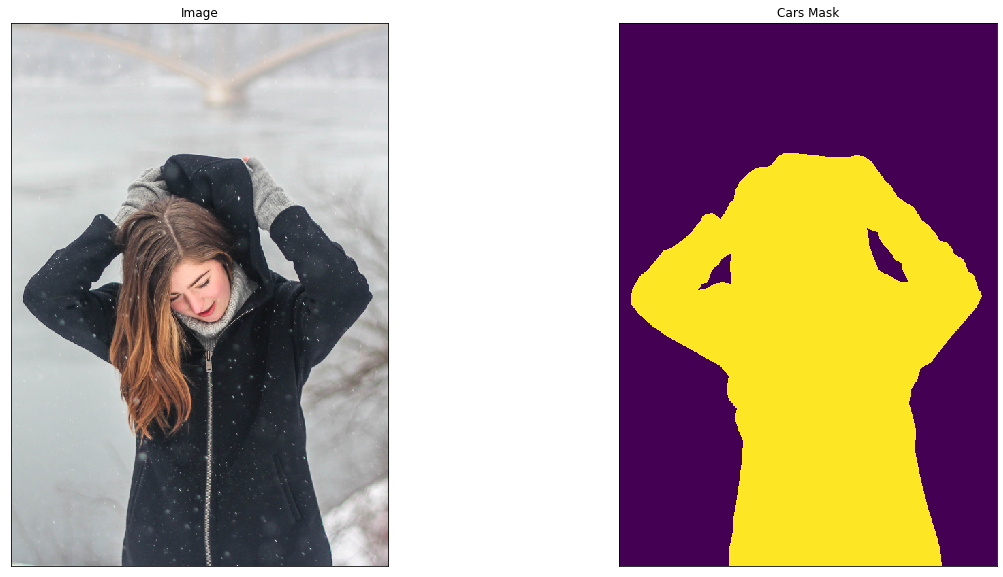

In [10]:
dataset = Dataset(X_train,classes=['person'])

image, mask = dataset[25] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [11]:
base_size = 480
def get_training_augmentation(size=480):
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=15, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=size, min_width=size, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=base_size, width=base_size, always_apply=True),
        
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.7,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.7,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.7,
        ),
        albu.OneOf(
            [
                albu.RandomResizedCrop(size,size,scale=[0.4,1.0]),
                albu.RandomResizedCrop(size,size,scale=[0.4,1.0],ratio=[1.0,1.0]),
                albu.RandomResizedCrop(size,size,scale=[0.4,1.0],ratio=[1.333333,0.75])
            ],
            p=1.0,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(size=480):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(size,size)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    #print(x.shape)
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

1.0


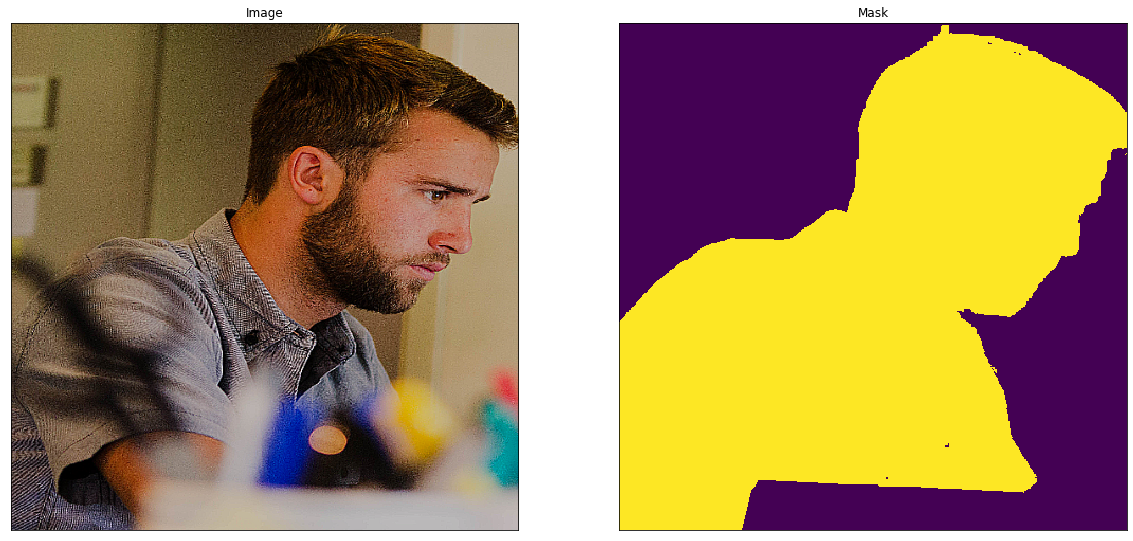

1.0


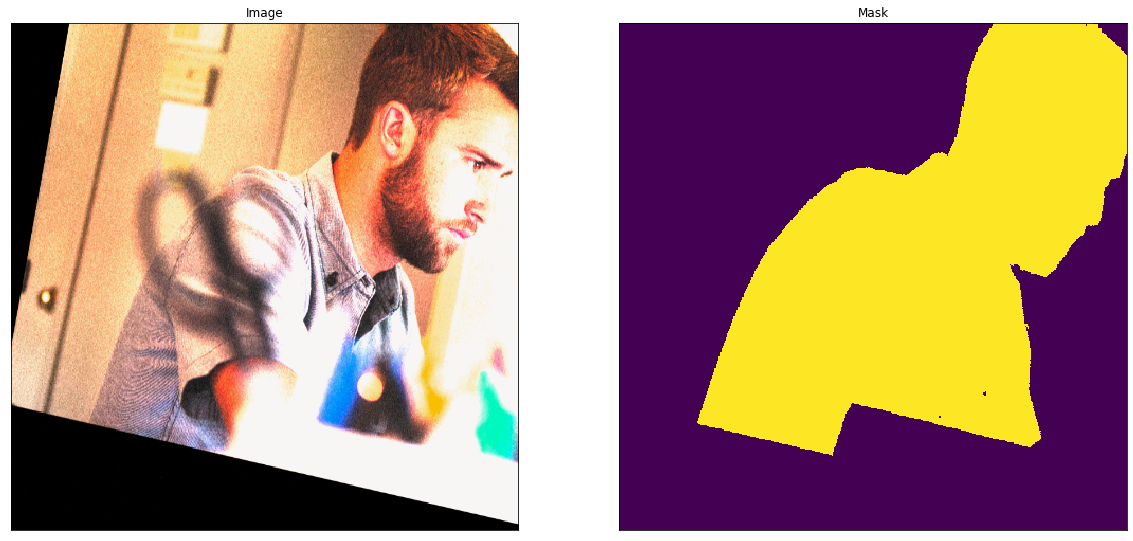

1.0


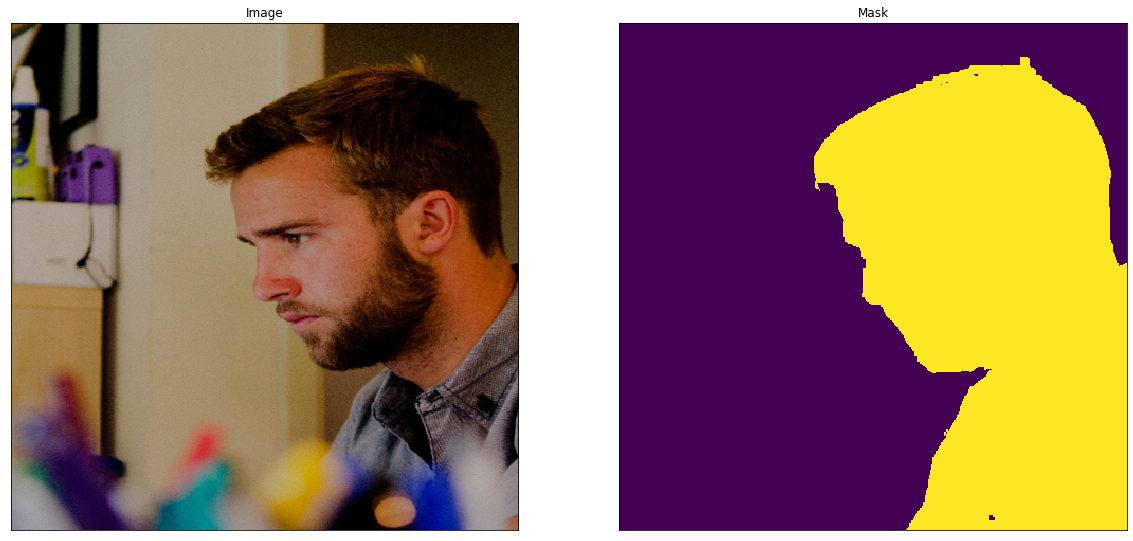

In [12]:
augmented_dataset = Dataset(
    X_train,
    classes=['plate'],
    augmentation=get_training_augmentation(size=480)
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[32]
    print(mask.max())
    visualize(image=image, mask=mask.squeeze())

In [13]:
#ENCODER = 'se_resnext50_32x4d'
ENCODER = 'timm-efficientnet-b1'
ENCODER_WEIGHTS = 'noisy-student'
DEVICE = 'cuda:0'

#CLASSES = ['plate']
ACTIVATION = 'sigmoid'

In [14]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
)
#model = torch.load('models/12_27/best_model_0.8768.pth')
#model = torch.load('/data/projects/plates_segmentation/models/best_model_night.pth')
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [15]:
model = nn.DataParallel(model)

In [16]:
train_dataset = Dataset(
    X_train,  
    augmentation=get_training_augmentation(size=480), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    X_test, 
    augmentation=get_validation_augmentation(size=480), 
    preprocessing=get_preprocessing(preprocessing_fn)
)
test_dataset = Dataset(
    X_test, 
    augmentation=get_validation_augmentation(size=480), 
    preprocessing=get_preprocessing(preprocessing_fn)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
valid_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

/home/AI/zhiganov.da/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2875: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [17]:
#loss = smp.utils.losses.JaccardLoss()
loss = L.JointLoss(nn.BCEWithLogitsLoss(), L.BinaryLovaszLoss())
#loss = L.JointLoss(L.BinaryFocalLoss(), L.BinaryLovaszLoss())
setattr(loss,'__name__','comboloss')
    
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5)
]

lr = 1e-4
optimizer = torch_optimizer.RAdam([ 
    dict(params=model.parameters(), lr=lr),
])#torch.optim

In [18]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0
best_name= None

logs_dict = {'train':[],'val':[]}
log_name = 'logs/log9.txt'
model_folder = str(time.localtime().tm_mon)+'_'+str(time.localtime().tm_mday)
try:
    os.mkdir('models/'+model_folder)
except:
    pass
for i in range(0, 30):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    with open(log_name,'a') as log:
        print('____'+'EPOCH '+str(i)+'____',file=log)
        print(train_logs,file=log)
        print(valid_logs,file=log)
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        best_logs = valid_logs
        if best_name:
            os.remove(best_name)
        best_name = 'models/'+model_folder+'/best_model_'+str(round(max_score,4))+'.pb'
        torch.save(model.module.state_dict(),best_name)
        print('Model saved!')
        
    if i>1 and i%12==0:
        lr = lr/10
        print(lr)
        optimizer.param_groups[0]['lr'] = lr
        print('Decrease decoder learning rate to {}'.format(lr))
with open(log_name,'a') as log:
    print('____'+'BEST SCORE'+'____',file=log)
    print(best_logs,file=log)


Epoch: 0
valid: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s, comboloss - 2.042, iou_score - 0.2071, fscore - 0.343] 
Model saved!

Epoch: 1
valid: 100%|██████████| 18/18 [00:13<00:00,  1.31it/s, comboloss - 1.826, iou_score - 0.6413, fscore - 0.7812]
Model saved!

Epoch: 2
valid: 100%|██████████| 18/18 [00:13<00:00,  1.35it/s, comboloss - 1.666, iou_score - 0.8005, fscore - 0.889] 
Model saved!

Epoch: 3
valid: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s, comboloss - 1.603, iou_score - 0.8328, fscore - 0.9086]
Model saved!

Epoch: 4
valid: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s, comboloss - 1.572, iou_score - 0.8523, fscore - 0.9202]
Model saved!

Epoch: 5
valid: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s, comboloss - 1.539, iou_score - 0.8607, fscore - 0.9251]
Model saved!

Epoch: 6
valid: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s, comboloss - 1.517, iou_score - 0.8726, fscore - 0.9319]
Model saved!

Epoch: 7
valid: 100%|██████████| 18/18 [00:13<00:00,  1.29it/

In [ ]:
valid_logs

In [7]:
time.localtime()

time.struct_time(tm_year=2019, tm_mon=12, tm_mday=27, tm_hour=14, tm_min=4, tm_sec=40, tm_wday=4, tm_yday=361, tm_isdst=0)

In [53]:
time.localtime()

time.struct_time(tm_year=2019, tm_mon=11, tm_mday=21, tm_hour=15, tm_min=44, tm_sec=9, tm_wday=3, tm_yday=325, tm_isdst=0)